In [1]:
# 1️⃣ Install & Import Library

import os              # Mengelola file dan folder (seperti mengambil list nama file di direktori)
import cv2             # Library utama untuk manipulasi gambar (load foto, resize, ubah warna)
import numpy as np     # Mengolah data gambar dalam bentuk array atau matriks angka
from tqdm import tqdm  # Menampilkan indikator proses (loading bar) saat mengolah banyak data

# Ekstraksi fitur HOG (Histogram of Oriented Gradients) dari gambar
from skimage.feature import hog

# Membagi dataset menjadi dua bagian: satu untuk latihan model, satu untuk pengujian
from sklearn.model_selection import train_test_split

# Menyamakan skala data (normalisasi) supaya proses hitungan model lebih stabil
from sklearn.preprocessing import StandardScaler

# Algoritma KNN untuk mengelompokkan data berdasarkan kemiripan terdekat
from sklearn.neighbors import KNeighborsClassifier

# Alat untuk melihat laporan hasil akhir, seperti persentase akurasi model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Mengecilkan dimensi data gambar agar proses komputasi lebih ringan dan cepat
from sklearn.decomposition import PCA

In [2]:
# 2️⃣ Mapping Label
# Daftar kategori ekspresi wajah yang akan diklasifikasikan
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Membuat dictionary secara otomatis
# Mengubah setiap label menjadi angka sesuai urutannya: 'angry': 0, 'disgust': 1, dst.
label_map = {label:i for i, label in enumerate(labels)}

# Menampilkan hasil pemetaan label ke angka
print(label_map)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [3]:
# Ekstraksi fitur HOG dari gambar
def extract_hog(image):
    features = hog(
        image, # Gambar input
        orientations=9, # Jumlah orientasi gradient
        pixels_per_cell=(8, 8), # ukuran sel dalam pixel
        cells_per_block=(2, 2), # jumlah sel dalam satu blok
        block_norm='L2-Hys' # metode normalisasi blok
    )
    return features

In [4]:
IMG_SIZE = 48 # Ukuran standar gambar yang akan diproses (48x48 pixel)

def load_all_data(base_path):
    X = []  # List penampung data gambar (fitur)
    y = []  # List penampung label angka (target)

    # Perulangan untuk mengakses folder 'train' dan 'validation' secara bergantian
    for split in ["train", "validation"]:
        # Perulangan untuk setiap kategori emosi yang ada di dalam folder split
        for label in labels:
            # Menyusun alamat folder (Contoh: dataset/train/happy)
            folder = os.path.join(base_path, split, label)
            
            # Melakukan perulangan pada setiap file gambar di folder tersebut
            for img in tqdm(os.listdir(folder)):
                img_path = os.path.join(folder, img)
                
                # Membaca gambar dalam mode hitam putih (Grayscale)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Menyamakan ukuran gambar menjadi 48x48 pixel
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                
                # Normalisasi nilai pixel (0-255) menjadi rentang (0-1)
                image = image / 255.0
                
                features = extract_hog(image)

                # Memasukkan data gambar ke X dan labelnya ke y
                X.append(features)
                y.append(label_map[label])

    # Mengembalikan data dalam format array NumPy
    return np.array(X), np.array(y)

In [5]:
# Memanggil fungsi load_all_data untuk folder utama "dataset"
# Hasilnya, semua gambar dari folder 'train' dan 'validation' digabung ke variabel X
# dan semua label emosinya digabung ke variabel y
X, y = load_all_data("dataset")

# Menampilkan total data yang berhasil diambil
# Outputnya akan menunjukkan (total_seluruh_gambar, 2304)
print(X.shape, y.shape)

100%|██████████| 797/797 [00:00<00:00, 2146.57it/s]


(35887, 900) (35887,)


In [6]:
# Tahap 1: Memisahkan data buat "Buku Pelajaran" (Train) dan "Bank Soal" (Temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,    # Artinya 30% data masuk ke Bank Soal, 70% buat Belajar
    stratify=y,       # Biar distribusi jenis emosinya adil/merata
    random_state=42   # Kunci pengacak biar hasilnya tetap sama tiap kali di-run
)

# Tahap 2: Membagi "Bank Soal" tadi jadi "Ujian Latihan" (Val) dan "Ujian Asli" (Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,    # 30% tadi dibagi dua lagi (50:50), jadi masing-masing dapat 15%
    stratify=y_temp,  # Tetap dijaga biar seimbang
    random_state=42   # Pakai kunci yang sama biar konsisten
)

# Cek berapa banyak foto di masing-masing tas
print("Data buat Belajar (Train):", X_train.shape)
print("Data buat Try-out (Validation):", X_val.shape)
print("Data buat Ujian Akhir (Test):", X_test.shape)

Data buat Belajar (Train): (25120, 900)
Data buat Try-out (Validation): (5383, 900)
Data buat Ujian Akhir (Test): (5384, 900)


In [7]:
# # 1. Kita siapkan alat "timbangan" atau "penggaris" standarnya
# scaler = StandardScaler()

# # 2. Si murid (X_train) belajar skala data sekaligus mengubah dirinya sendiri
# # fit_transform artinya: Cari rata-rata data, lalu ubah datanya jadi standar
# X_train = scaler.fit_transform(X_train)

# # 3. Gunakan "penggaris" yang sama untuk data latihan ujian dan ujian asli
# # Kita cuma pakai .transform() karena kita gak boleh belajar lagi dari data ujian,
# # kita cuma boleh menyesuaikan ukurannya biar sama dengan data belajar.
# X_val   = scaler.transform(X_val)
# X_test  = scaler.transform(X_test)

In [8]:
# 1. Kita siapkan alat "timbangan" atau "penggaris" standarnya
scaler = StandardScaler()

# 2. Si murid (X_train) belajar skala data sekaligus mengubah dirinya sendiri
X_train = scaler.fit_transform(X_train) # fit_transform artinya: Cari rata-rata data, lalu ubah datanya jadi standar
X_val = scaler.transform(X_val) # transform artinya: Gunakan penggaris yang sudah dipelajari untuk mengubah data ini
X_test = scaler.transform(X_test) # sama tapi untuk data ujian asli

# 3. Terapkan PCA untuk mereduksi dimensi data menjadi 150 fitur utama
pca = PCA(n_components=150)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)


In [9]:
# # 1. Kita tentukan mau diringkas jadi berapa banyak info utama
# # Dari 2304 pixel (fitur), kita cuma mau ambil 100 "inti" paling penting saja
# pca = PCA(n_components=100)

# # 2. Si data belajar (X_train) mencari pola utama lalu merampingkan dirinya
# # fit_transform: Pelajari cara meringkas yang benar, lalu terapkan
# X_train = pca.fit_transform(X_train)

# # 3. Data ujian (Val & Test) ikut diringkas pakai cara yang sudah dipelajari tadi
# # Sama seperti scaling, kita nggak boleh "belajar" lagi dari data ujian
# X_val   = pca.transform(X_val)
# X_test  = pca.transform(X_test)

BERIKUT BAGAIMANA PCA BEKERJA
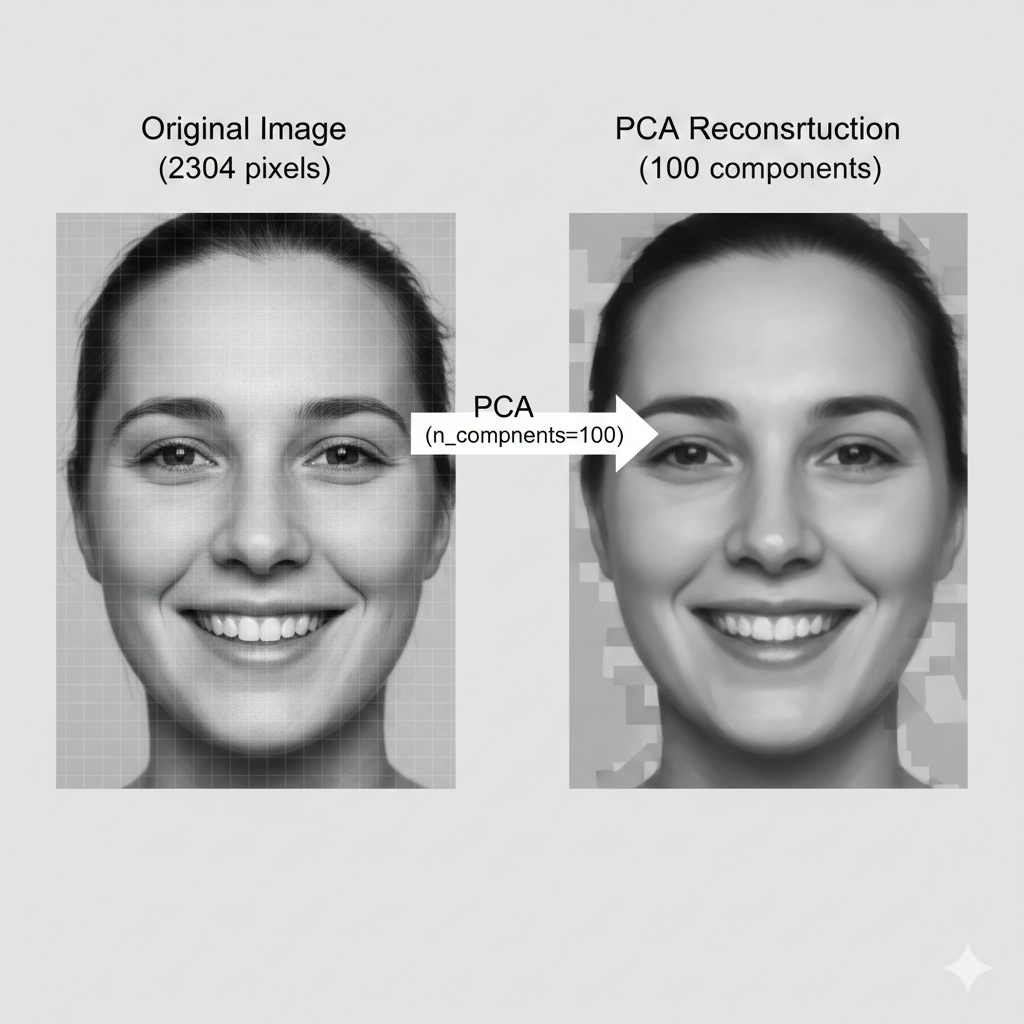

In [10]:
# Kita siapkan catatan kosong dulu buat nyimpen siapa yang paling juara
best_k = 0
best_acc = 0

# Kita suruh modelnya nyoba beberapa opsi jumlah "tetangga" (k)
for k in [3, 5, 7, 9, 11]:
    # 1. Inisialisasi KNN dengan jumlah tetangga (k) dan cara hitung jarak "cosine"
    # metric="cosine" artinya dia ngitung kemiripan wajah berdasarkan sudut/pola, bukan cuma jarak lurus
    # weights="distance" artinya tetangga yang lebih dekat bobotnya lebih besar pengaruhnya
    knn = KNeighborsClassifier(
        n_neighbors=k,
        metric="cosine",
        weights="distance"
    )
    
    # 2. Si model belajar dari data latihan (X_train)
    knn.fit(X_train, y_train)
    
    # 3. Kita tes modelnya pake soal latihan/Try-Out (X_val)
    val_pred = knn.predict(X_val)
    
    # 4. Itung dapet nilai berapa si murid di Try-Out ini
    acc = accuracy_score(y_val, val_pred)

    print(f"k={k}, val acc={acc}")

    # 5. Kalau hasil k yang sekarang lebih bagus dari yang sebelumnya, simpan sebagai juara!
    if acc > best_acc:
        best_acc = acc
        best_k = k

# Kasih tau hasil akhirnya siapa pemenangnya
print("Best k:", best_k)

k=3, val acc=0.5106817759613599
k=5, val acc=0.5182983466468511
k=7, val acc=0.5253576072821846
k=9, val acc=0.52925877763329
k=11, val acc=0.5305591677503251
Best k: 11


In [11]:
# 1. Kita buat model KNN "final" menggunakan k yang sudah terbukti paling juara (best_k)
final_knn = KNeighborsClassifier(n_neighbors=best_k, metric="cosine")

# 2. Si model belajar sekali lagi dari seluruh data latihan
final_knn.fit(X_train, y_train)

# 3. Waktunya Ujian Akhir! Kita suruh model menebak emosi dari data yang belum pernah dilihat (X_test)
test_pred = final_knn.predict(X_test)

# 4. Memanggil alat untuk membuat laporan rapor kelulusan
from sklearn.metrics import classification_report

# 5. Cetak laporan lengkapnya. target_names=labels gunanya supaya muncul tulisan 
# 'happy', 'sad', dll., bukan cuma angka 0, 1, 2...
print(classification_report(y_test, test_pred, target_names=labels))

              precision    recall  f1-score   support

       angry       0.40      0.43      0.41       743
     disgust       0.46      0.28      0.35        82
        fear       0.39      0.28      0.32       768
       happy       0.57      0.79      0.66      1349
     neutral       0.45      0.42      0.44       930
         sad       0.40      0.32      0.36       912
    surprise       0.61      0.52      0.56       600

    accuracy                           0.49      5384
   macro avg       0.47      0.43      0.44      5384
weighted avg       0.47      0.49      0.47      5384



In [12]:
import joblib
import numpy as np

joblib.dump(final_knn, "model_knn.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
np.save("labels.npy", labels)